__Нейросетевая языковая модель на основе схемы Seq2Seq__

Евгений Борисов <esborisov@sevsu.ru>

---

# загружаем тексты

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [3]:
# url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# # with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [4]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [6]:
# !pip install torch

In [7]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [8]:
# !pip install torchtext

In [9]:
# import torchtext
# from torchtext.data import get_tokenizer

In [10]:
seq_len = 5

In [11]:
class SeqDataset(Dataset):
    
    def __init__(self, text, seq_len=seq_len ):
        assert seq_len>1
        assert len(text)>1
        
        self._tokens = ['<UNK>','<EOS>',] # служебные токены "неизвестное слово", "конец последовательности"
        
        self._seq_len = seq_len # количество слов контекста слева 
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._seq_len*2 ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) ) 
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._seq_len*2 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else self._tokens['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
                self._data[idx,:seq_len], 
                self._data[idx,seq_len:], 
            )
    
    def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
        return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences
    
    @property
    def sentence_len(self): return self._seq_len

In [12]:
ds = SeqDataset( text=text, seq_len=seq_len )

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/3754 [00:00<?, ?it/s]

  0%|          | 0/69399 [00:00<?, ?it/s]

In [13]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

69399

3754

24068

24067

In [14]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [15]:
# ds[1]

# модель

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class Encoder(nn.Module):
    def __init__(self, vocabulary, seq_len, embedding_dim=128, hidden_dim=256,): 
        super().__init__()
        self._vocabulary = vocabulary
        self._seq_len = seq_len
        self._emb = nn.Embedding(len(vocabulary), embedding_dim)
        self._gru = nn.GRU(
                input_size=embedding_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )

    def forward(self, x):
        o = self._emb(x)
        o, h = self._gru(o)
        return o,h

In [18]:
class Decoder(nn.Module):
    
    def __init__(self, vocabulary, hidden_dim, seq_len):
        super(Decoder, self).__init__()
        self._vocabulary = vocabulary
        self._seq_len = seq_len
        
        self._emb = nn.Embedding(num_embeddings=len(vocabulary),embedding_dim=hidden_dim)
        self._gru = nn.GRU( 
                input_size=hidden_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )
        self._lin = nn.Linear(in_features=hidden_dim, out_features=len(vocabulary),bias=True,)

        
    def forward(self, encoder_hidden):
        device = next(self._lin.parameters()).device
        batch_size = encoder_hidden.size(1)
        
        input_ = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        hidden = encoder_hidden
        outputs = []

        for i in range(self._seq_len):
            output, hidden  = self._forward_step(input_,hidden)
            outputs.append(output)
            # input_ = torch.argmax(output,dim=-1, keepdim=False) 
            _, topi = output.topk(1) # argmax
            input_ = topi.squeeze(-1).detach() 
        return torch.cat(outputs, dim=1)
                
        
    def forward_train(self, encoder_hidden, target_tensor):
        device = next(self._lin.parameters()).device
        batch_size = encoder_hidden.size(1)
        
        input_ = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        hidden = encoder_hidden
        outputs = []

        for i in range(self._seq_len):
            output, hidden  = self._forward_step(input_,hidden)
            outputs.append(output)
            # teacher forcing: заменяем выход модели на предыдущей итерации на target
            input_ = target_tensor[:,i].unsqueeze(1) 
            # input_ = target_tensor[:,[i]]
        return torch.cat(outputs, dim=1)
    
    def _forward_step(self,x,h):
        o = self._emb(x)
        o,h = self._gru(o,h)
        o = self._lin(o)
        o = F.log_softmax(o,dim=-1)
        return o,h

In [21]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [22]:
embedding_dim = 128
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocabulary=ds.vocabulary, 
        embedding_dim=embedding_dim,
        hidden_dim=encoder_hidden_dim,
        seq_len=seq_len,
    ).to(device)

model_decoder = Decoder( 
        hidden_dim=encoder_hidden_dim, 
        vocabulary=ds.vocabulary, 
        seq_len=seq_len,
    ).to(device)

# обучаем 

In [23]:
from torch import optim

learning_rate = 1e-2
encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [24]:
# история значений ф-ции потери
loss_history = [] 

In [25]:
from torch.utils.data import DataLoader

In [26]:
%%time

n_epoch = 64 # количество эпох обучения
batch_size = 1024*12

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for input_tensor, target_tensor in DataLoader( ds, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        _, encoder_hidden = model_encoder(input_tensor.to(device))
        decoder_outputs = model_decoder.forward_train( encoder_hidden, target_tensor.to(device))
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
    

  0%|          | 0/64 [00:00<?, ?it/s]

CPU times: user 4min 10s, sys: 239 ms, total: 4min 10s
Wall time: 4min 2s


Text(0.5, 1.0, 'min loss: 0.11125')

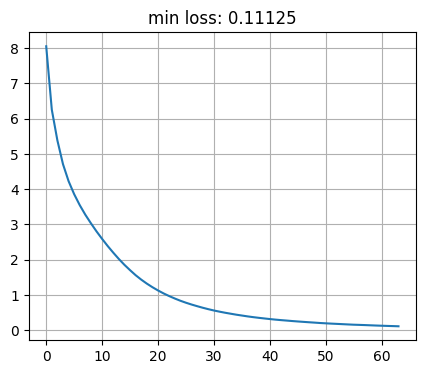

In [27]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [28]:
from random import sample
from nltk.util import ngrams 

prompts = [
    ' '.join(ng) 
    for s in sample( ds.sentences,10 ) if len(s)>ds.sentence_len*2
    for ng in list(ngrams(s[:ds.sentence_len],5))  
    ]

display( prompts )

['В любую минуту может вынырнуть',
 'Когда нас начали пропускать к',
 'Увидев меня в дверях в',
 '-- спросил я. Нужно же',
 'Еще Узбек , который в',
 'Китайца я должен подобрать в',
 'Отец девочек поставил его в',
 'Зная это , не так',
 'Фигура в черной мантии зашевелилась',
 'Лучше посмотри на мою фамилию35']

In [29]:
class LangModelSeq2Seq: # генератор текста 
    
    def __init__(self,encoder,decoder,vocabulary):
        self._encoder = encoder 
        self._decoder = decoder 
        self._vocabulary = vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
    
    def predict(self,prompt,n_iter=1):
        eos = self._vocabulary['<EOS>']
        x = self._encode(prompt) # начальная последовательность токенов
        codes = []
        for _ in range(n_iter):
            p = self._predict(x) # генерируем следующий токен
            codes.append(p)
            if (p==eos).any():break
            x = torch.tensor(p.reshape(1,-1,),dtype=torch.long)
            #print(x)
        return self._strip_eos( self._decode(np.hstack(codes)) ) # конвертируем коды токенов в строку

    def _predict(self,x):
        device = next(self._encoder.parameters()).device 
        with torch.set_grad_enabled(False): # генерируем следующий токен
            _,h = self._encoder(x.to(device))
            o   = self._decoder(h)
        return np.argmax( o.cpu().numpy()[0],axis=1) 
    
    def _encode(self,s): # кодируем строку
        s = nltk_tokenize_word(s,language='russian')
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )
    
    def _decode(self,s): # конвертируем коды токенов в строку
        return ' '.join([ 
            self._vocabulary_inv[c] 
            for c in s if (c in self._vocabulary_inv) 
        ])
    @staticmethod
    def _strip_eos(s,eos='<EOS>'):
        n = s.find(eos)
        return s if n<0 else s[:n+len(eos)]

In [30]:
for prompt in prompts:
    t = LangModelSeq2Seq(model_encoder,model_decoder,ds.vocabulary).predict(prompt,n_iter=25)
    print(prompt,'==>', t,'\n')

В любую минуту может вынырнуть ==> из-за угла синий `` додж '' с инспекторами комиссии такси , собрать требуемую сумму практически в Квинс пустым . <EOS> 

Когда нас начали пропускать к ==> Гелию , его истощенные , высохшие руки были еще способны какой я кэбби , если очередь тронется , и -- бегом за два квартала , к тележке под полосатым зонтом , и без всякого энтузиазма слушали , как я очень увлекательно рассказывал им , что взял под `` Американец '' на протяжении дня две `` .Па-Гвардии '' и два `` Хилтона '' , -- `` бляшка '' , а вообще-то о медальоне никакой таксист так же , как и прежние , станут увещевать его , а иной раз и одергивать , чтобы он не выплескивал в эфир всю ту правду о закрытом обществе , которую удавалось выискать и собрать по крупицам ; что вполне достаточно сказать половину этой уродливой правды , а машины вокруг -- 

Увидев меня в дверях в ==> такое необычное время , жена побледнела , как полотно , но тут же по выражению моего лица поняла , что ничего плохого не 